# Lasso Regression Model

# DataFrame Imports

This notebook contains a basic Lasso regression with GridSearch and a pipeline with parameters. 

You will see the data cleaning, exploratory data analysis (EDA), preporcessing, modeling, and lastly evulation to submit to the Kaggle Competition. 

*Lasso Regression will be referred to as 'lasso' or 'lass' throughout the text

In [1]:
#First import the Libraries & tools needed to comeplete the Lasso Regression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer


In [2]:
#Import the TRAINING data
#Using .head() to see what columns exist and the values with inside

training = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/train.csv')
training.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
# Import the TEST Data that is given
testing = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/test.csv')
testing.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [4]:
#The is to import the sample_sub data set.

sample_sub = pd.read_csv('/Users/khalildavis/Desktop/General Assembly Work/Submissions/Projects/Project 2 Final Submits/Data Sets/sample_sub_reg_origin.csv')
sample_sub.head(2)

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217


# EDA

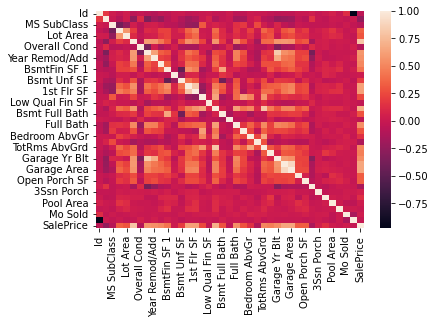

In [5]:
#See correlation model of the training set to help choose with features to try in the model
sns.heatmap(training.corr());

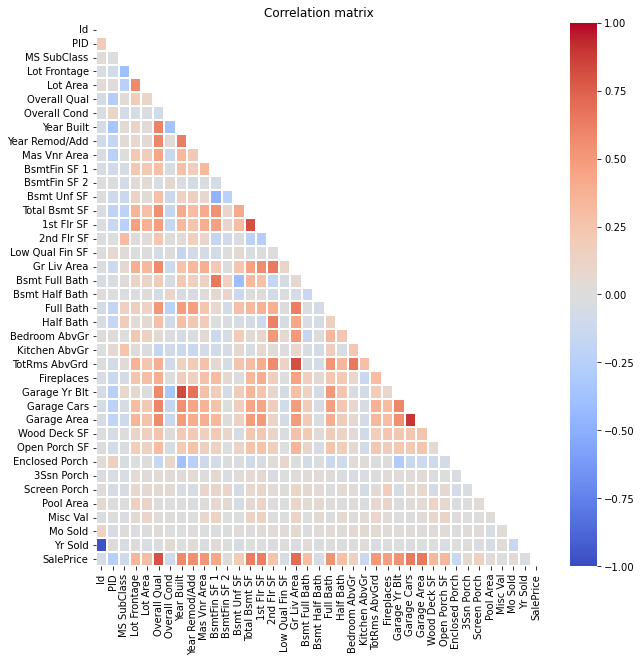

In [6]:
#Create a correlation Matrix for the features, to have a better view.

mask = np.zeros_like(training.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(
    training.corr(),
    cmap='coolwarm',
    annot=False,
    mask=mask,
    vmin=-1.,
    vmax=1.,
    linewidths=.1,
    center=0
)

plt.title('Correlation matrix'); 

Once I have choosen the features I would like to use, I start to prepare for the Train_Test_Split by stating my X and y.

In [7]:
X = training[['Lot Area','Overall Qual', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
'1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',   
'Full Bath', 'Half Bath', 'Bedroom AbvGr',  
'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF','Open Porch SF',         
'Screen Porch'
]]

y = training['SalePrice'] 

In [8]:
#Performed 'tts' with random state to have continous numbers through out the models

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=444)

# Data Cleaning & Preprocessing

To clean the data to use within the tts, I will be using Simple Imputer to help filling in missing data cells within the training and testing data sets. 

Since its a basic Lasso with GridSearch, I have choosen the strategy='mean' because majority of the features I am starting with a numeric. If the features were catergorical, I would have choosen strategy='most_frequent' aka the mode. 

In [9]:
#Imported SimpleImputer to fill missive values by 'mean'
#Instantiating the Simpe Imputer

si = SimpleImputer(strategy='mean')

In [10]:
#Fit & transform Simple Imputer to the training data

X_train_filled = si.fit_transform(X_train, y_train)

In [11]:
#Create a new data frame to keep the changes that have been made with the training and testing set.

X_train_filled = pd.DataFrame(X_train_filled, columns=X_train.columns)

In [12]:
#Checking to see all rows and columns are filled

X_train_filled.isna().sum()

Lot Area          0
Overall Qual      0
BsmtFin SF 1      0
Bsmt Unf SF       0
Total Bsmt SF     0
1st Flr SF        0
2nd Flr SF        0
Gr Liv Area       0
Bsmt Full Bath    0
Full Bath         0
Half Bath         0
Bedroom AbvGr     0
TotRms AbvGrd     0
Fireplaces        0
Garage Cars       0
Garage Area       0
Wood Deck SF      0
Open Porch SF     0
Screen Porch      0
dtype: int64

In [13]:
#Only transform the testing set

X_test_filled = si.transform(X_test)

The use of Lasso for a regression model is to for one help with feature selection by eliminating features that are useless and redundant. It also helps with minimizing errors to the point of zero by using parameters as a restraint.
I am starting with such a low alpha because to minimize the sum of square of coefficients and will increase as the parameters or features change.

In [14]:
#Instantating the Lasso model with an alpha of .01 to start with

lasso = Lasso(alpha=.01)


In [15]:
#This is great to follow my steps with the pipe and gridsearch.

from sklearn import set_config
set_config(display='diagram')

In [16]:
#Making a pipeline to scale the data while creating polynomial features

pipe2 = make_pipeline(
PolynomialFeatures(),
StandardScaler(),
Lasso(),

)

When it comes to Lasso you must set parameters to help determine the coefficients. Lastly, using an range of alphas that the model can iterate through to determine what are the best features and parameters to have a succesful model

In [17]:

params2 = {
'polynomialfeatures__interaction_only': [True, False],
'lasso__alpha': [.01,0.1, 1, 10, 100]

}

In [18]:
#Decided to add GridSearCV to really have the best chance of creating an efficient model

gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)

In [19]:
#Fitting the gridsearch to the traning data

gs2.fit(X_train_filled, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.077e+11, tolerance: 7.897e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.916e+11, tolerance: 7.934e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e+11, toleranc

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.01, 0.1, 1, 10, 100],
                         'polynomialfeatures__interaction_only': [True, False]})

In [20]:
#Putting my cv_results into a data frame
#Then taking a look at the rank, mean test score, alphas and parameters to see which model did the best

pd.DataFrame(gs2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_polynomialfeatures__interaction_only,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.417751,0.007128,0.005850,0.000465,0.01,True,"{'lasso__alpha': 0.01, 'polynomialfeatures__in...",0.900017,0.887822,0.855903,0.761521,0.323361,0.745725,0.216692,6
1,0.464780,0.010560,0.007614,0.001444,0.01,False,"{'lasso__alpha': 0.01, 'polynomialfeatures__in...",0.886234,0.868298,0.858071,0.828634,0.146395,0.717527,0.286176,10
2,0.429758,0.005797,0.005940,0.000211,0.1,True,"{'lasso__alpha': 0.1, 'polynomialfeatures__int...",0.900032,0.887848,0.855933,0.761599,0.323629,0.745808,0.216598,5
3,0.475819,0.008153,0.006526,0.001302,0.1,False,"{'lasso__alpha': 0.1, 'polynomialfeatures__int...",0.886268,0.868352,0.858123,0.828642,0.147394,0.717756,0.285793,9
4,0.433550,0.011684,0.006496,0.002161,1,True,"{'lasso__alpha': 1, 'polynomialfeatures__inter...",0.900184,0.888096,0.856222,0.762176,0.326694,0.746674,0.215495,4
5,0.494793,0.008844,0.006371,0.002814,1,False,"{'lasso__alpha': 1, 'polynomialfeatures__inter...",0.886637,0.869013,0.858577,0.828803,0.156204,0.719847,0.282446,8
6,0.441346,0.016276,0.007558,0.003968,10,True,"{'lasso__alpha': 10, 'polynomialfeatures__inte...",0.902829,0.890381,0.860603,0.773477,0.349257,0.755309,0.207991,3
7,0.512919,0.009099,0.007918,0.003284,10,False,"{'lasso__alpha': 10, 'polynomialfeatures__inte...",0.891143,0.876902,0.863181,0.830277,0.215206,0.735342,0.260849,7
8,0.385667,0.007798,0.006591,0.002615,100,True,"{'lasso__alpha': 100, 'polynomialfeatures__int...",0.906257,0.895475,0.872877,0.840145,0.456660,0.794283,0.170322,1
9,0.339421,0.057104,0.004544,0.000454,100,False,"{'lasso__alpha': 100, 'polynomialfeatures__int...",0.903894,0.895337,0.875292,0.836998,0.405107,0.783326,0.190511,2


In [21]:
#Getting the best parameters from the GridSearch

gs2.best_params_

{'lasso__alpha': 100, 'polynomialfeatures__interaction_only': True}

In [22]:
gs2.score(X_test_filled, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


0.8492644287012828

In [23]:
gs2.score(X_train_filled, y_train)

0.9117112414867508

In [24]:
#Increased the number of features I am using.

gs2_preds = gs2.predict(testing[['Lot Area','Overall Qual', 'BsmtFin SF 1', 'Bsmt Unf SF', 'Total Bsmt SF',
'1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath',   
'Full Bath', 'Half Bath', 'Bedroom AbvGr',  
'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF','Open Porch SF',         
'Screen Porch']])

gs2_preds

array([170047.95560055, 167438.78007454, 195835.39021976, 110136.40126607,
       181655.98453473,  94102.61900042,  94287.54796364, 138548.28024429,
       172173.09250646, 172489.20916518, 149410.61131432, 130303.24574371,
       154277.51311317, 299230.01508456, 152897.18493254, 118812.1081363 ,
       187588.06524301, 119554.12386311, 209788.830927  , 231379.54858739,
       130075.61154662, 166093.59638323, 194746.25625195, 195326.83721764,
       189109.26821738, 112055.50389491, 119724.63750335, 111680.72981197,
       148897.83098973,  67238.06318405, 102022.99476566,  99864.61463357,
       255027.33195416, 152498.52114403, 201391.93342375, 162543.17645081,
       113042.39452132,  96545.67103163, 108812.57759698, 192810.08258006,
       145297.26779022, 212443.03102033, 133127.36954403, 161976.18810537,
       221403.8048299 ,  87674.20423955, 214062.09858637, 121447.20619302,
       110674.48957038, 133338.89612061, 116367.56589545, 202477.15107337,
       257333.99504402, 1

In [25]:
gs2_preds.shape

(878,)

In [26]:
y_preds2 = gs2.predict(X_test_filled)
y_preds2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([303614.33196405,  82578.95828802, 164609.95944733, 123948.15702147,
       221817.96622158, 167568.70343637, 145271.24898802, 119205.51230687,
       194926.13224048, 125605.89311408, 149632.73236203, 226791.68302835,
       215330.91749905, 260674.90509121, 361836.05473581, 364612.06955801,
       134242.36007485, 261445.10193939, 361985.8656954 , 206776.41103634,
       133902.85878974, 190397.67184552, 140240.09104255, 128826.80938967,
       155433.39117462, 206365.58194881, 371303.46149856, 288756.85858521,
       177175.86343276, 109343.11825538, 181188.36694523, 258085.8092645 ,
       253694.1231182 , 107407.08250689, 184959.77980164, 134747.64587663,
        83929.5784534 , 257785.36142342, 230389.29925824,  98748.72103505,
       115223.59742832, 112894.27646356, 102775.13317705,  75367.94363484,
       125876.48195273, 290964.05529991, 105559.5176305 ,  95626.85134247,
       196917.30152767, 146038.24967139, 125858.54134498, 346035.43476515,
       159180.43643706, 1

In [27]:
y_preds2.shape

(513,)

In [28]:
lasso.fit(X_test_filled, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.396e+11, tolerance: 3.136e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.01)

In [29]:
lasso.intercept_

-103056.06534763327

In [30]:
lasso.coef_

array([ 8.21650028e-01,  2.63182039e+04,  1.27853639e+01,  1.25847474e+01,
       -1.73888040e+01,  9.01972417e+01,  6.39320811e+01, -5.43282297e+01,
        1.24563154e+04,  1.37672623e+04,  6.38873176e+03, -3.04703744e+03,
        2.61556411e+03,  4.71519287e+03,  1.30392102e+04,  8.57956769e+00,
        4.57231750e+01,  5.52854139e+01,  9.07259284e+01])

In [31]:
lasso.coef_.mean()

4029.597954088015

**Evaluation:**
The Lasso model with gridsearchcv, pipeline, polynomial features have proved to be my best model yet. The RMSE on testing_filled data is $30,357 which is my lowest prediction yet. 
Increasing the number of features I have in this model has helped and with lasso, it has decreased the reduncy of features to help focus in on the ones that most important. Even the R^2 values for validation have been the highest yet.
Lastly, the coefficients and intercept have shrunk to let me know lasso model is performing at a high level. 

In [32]:
mean_squared_error(y_test, y_preds2, squared=False)

30357.529947301347

In [33]:
testing['SalePrice'] = gs2_preds

In [34]:
#Submit to Kaggle #$26,773

testing[['Id', 'SalePrice']].to_csv('Gs_pipe2_Lasso.5F.csv', index=False)

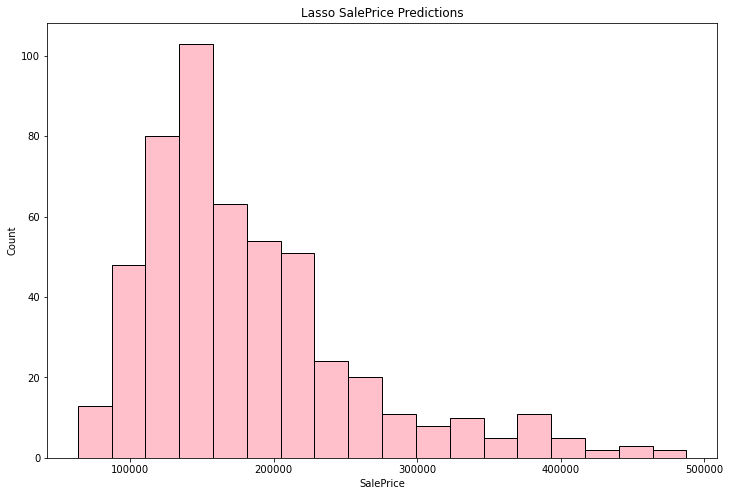

In [35]:
plt.figure(figsize = (12, 8))   

plt.hist(y_preds2, color ='pink', bins=18, ec = 'black');

plt.title('Lasso SalePrice Predictions');
plt.xlabel('SalePrice')
plt.ylabel('Count');